In [1]:
import os
from rdkit import Chem
from smiles_to_graph import graph_data_from_smiles_and_labels, graph_data_from_mol_and_labels
from graph_models.mxmnet.model import MXMNetModel
from graph_models.pamnet.model import PAMNetModel
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

# Получаем молекулярный граф

### Граф из SMILES без лейблов и без координат но с водородами

In [2]:
smiles = 'CCC1=NC=CN1C2=CC=CC(=N2)C3CCCN3C(=O)C4=CC=C(C=C4)OCCN(C)C'

graph_data_from_smiles_and_labels(smiles, with_hydrogen=True, with_coords=False)

Data(x=[63, 79], edge_index=[2, 132], edge_attr=[132, 10], z=[63], smiles='CCC1=NC=CN1C2=CC=CC(=N2)C3CCCN3C(=O)C4=CC=C(C=C4)OCCN(C)C')

### Граф из SMILES c лейблами без водородов

In [3]:
smiles = 'CCC1=NC=CN1C2=CC=CC(=N2)C3CCCN3C(=O)C4=CC=C(C=C4)OCCN(C)C'
y = [0., 1., 2.]

graph_data_from_smiles_and_labels(smiles, with_hydrogen=False, with_coords=True, y=y)

Data(x=[32, 79], edge_index=[2, 70], edge_attr=[70, 10], z=[32], y=[1, 3], smiles='CCC1=NC=CN1C2=CC=CC(=N2)C3CCCN3C(=O)C4=CC=C(C=C4)OCCN(C)C', pos=[32, 3])

### Граф из SDF без лейблов

In [4]:
mol = Chem.SDMolSupplier(os.path.join('data','CID_110094592.sdf'), removeHs=False)[0]

graph_data_from_mol_and_labels(mol, with_hydrogen=True, with_coords=True)

Data(x=[63, 79], edge_index=[2, 132], edge_attr=[132, 10], z=[63], smiles='[H]c1nc(C([H])([H])C([H])([H])[H])n(-c2nc([C@@]3([H])N(C(=O)c4c([H])c([H])c(OC([H])([H])C([H])([H])N(C([H])([H])[H])C([H])([H])[H])c([H])c4[H])C([H])([H])C([H])([H])C3([H])[H])c([H])c([H])c2[H])c1[H]', pos=[63, 3])

# Получаем векторное представление молекулы

In [5]:
device = 'cuda'

model = PAMNetModel.load_from_checkpoint('model_checkpoints/PAMNET_checkpoint-epoch=04-val_loss=0.29.ckpt', map_location=torch.device(device))

### Вектор из SMILES

In [6]:
smiles = ['CCC1=NC=CN1C2=CC=CC(=N2)C3CCCN3C(=O)C4=CC=C(C=C4)OCCN(C)C', 
          'CC(C)C1C2=C(CCN1CC3=NC(=NO3)C4=CC=CC=N4)C5=CC=CC=C5N2',
          'CC1=NC(=NO1)C2(CCCCC2)NC(=O)C3=CC=C(C=C3)OC(F)F']

data_list = []
for smile in smiles:
    data = graph_data_from_smiles_and_labels(smile, with_hydrogen=False, with_coords=True)
    data_list.append(data)

with torch.no_grad():
    embeds = model(Batch.from_data_list(data_list).to(device))['embeds']
    
embeds.shape

torch.Size([3, 128])

### Визуализируем векторное представление для аминокислот

In [7]:
aminoacids_smiles = {
    "A": "C[C@@H](C(=O)O)N",
    "R": "C(C[C@@H](C(=O)O)N)CN=C(N)N",
    "N": "C([C@@H](C(=O)O)N)C(=O)N",
    "D": "C([C@@H](C(=O)O)N)C(=O)O",
    "C": "C([C@@H](C(=O)O)N)S",
    "Q": "C(CC(=O)N)[C@@H](C(=O)O)N",
    "E": "C(CC(=O)O)[C@@H](C(=O)O)N",
    "G": "C(C(=O)O)N",
    "H": "C1=C(NC=N1)C[C@@H](C(=O)O)N",
    "I": "CC[C@H](C)[C@@H](C(=O)O)N",
    "L": "CC(C)C[C@@H](C(=O)O)N",
    "K": "C(CCN)C[C@@H](C(=O)O)N",
    "M": "CSCC[C@@H](C(=O)O)N",
    "F": "C1=CC=C(C=C1)C[C@@H](C(=O)O)N",
    "P": "C1C[C@H](NC1)C(=O)O",
    "S": "C([C@@H](C(=O)O)N)O",
    "T": "C[C@H]([C@@H](C(=O)O)N)O",
    "W": "C1=CC=C2C(=C1)C(=CN2)C[C@@H](C(=O)O)N",
    "Y": "C1=CC(=CC=C1C[C@@H](C(=O)O)N)O",
    "V": "CC(C)[C@@H](C(=O)O)N"
}

In [8]:
# visualize embeddings

data_list = []

for aa in aminoacids_smiles:
    data = graph_data_from_smiles_and_labels(aminoacids_smiles[aa], with_hydrogen=False, with_coords=True)
    data_list.append(data)


with torch.no_grad():
    embeds = model(Batch.from_data_list(data_list).to(device))['embeds'].cpu().numpy()


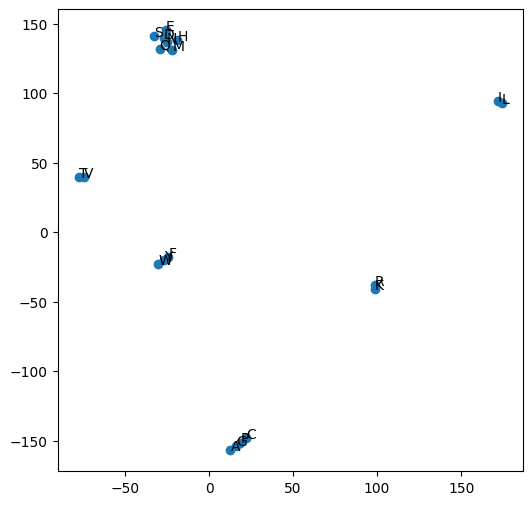

In [9]:
tsne = TSNE(n_components=2, random_state=42, perplexity=1, n_iter=500)

tsne_embeds = tsne.fit_transform(embeds)

plt.figure(figsize=(6, 6))
plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1])
for i, aa in enumerate(aminoacids_smiles):
    plt.annotate(aa, (tsne_embeds[i, 0], tsne_embeds[i, 1]))
    
plt.show()  